In [155]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Importing Data

In [156]:
# import TCP23_data.xlsx sheet Q1 E-bike Sales as df starting at row 6 and end at row 22
df = pd.read_excel('TCP23_data.xlsx', sheet_name='Q1 E-bike Sales', skiprows=6, nrows=17)

locations = ['US', 'Europe', 'France', 'China', 'India', 'Japan']

#rename rows to Year, US, Europe, France, China, India, Japan
df.columns = ['Year'] + locations

#focus on US and Europe data
df = df[['Year', 'US', 'Europe']]
locations = ['US', 'Europe']

# convert year data to int
df['Year'] = df['Year'].astype(int)

## Splitting Data by Location

In [157]:
# separate into data frames for each location with year
dataframes = {location: df[['Year', location]] for location in locations}

# for each df, drop all rows with no data
for location, df in dataframes.items():
    dataframes[location] = df[df[location] != '--']

# convert all values to numbers
for location, df in dataframes.items():
    dataframes[location][location] = pd.to_numeric(df[location])

# define market size for locations in 1000s of people
market_size = {'US': 255000, 'Europe': 108329, 'UK': 33943 }

# show us data head
print(dataframes['US'].head())

# divide data by market size
for location, df in dataframes.items():
    dataframes[location][location] = df[location] / market_size[location]

# for each dataframe create a column for cumulative sum
for location, df in dataframes.items():
    dataframes[location]['cum_sum'] = df[location].cumsum()

# for each dataframe create a new column with year minus first year
for location, df in dataframes.items():
    dataframes[location]['year_diff'] = df['Year'] - df['Year'].iloc[0]

# show us data head
print(dataframes['US'].head())

    Year   US
11  2017  263
12  2018  369
13  2019  423
14  2020  416
15  2021  750
    Year        US   cum_sum  year_diff
11  2017  0.001031  0.001031          0
12  2018  0.001447  0.002478          1
13  2019  0.001659  0.004137          2
14  2020  0.001631  0.005769          3
15  2021  0.002941  0.008710          4


## Defining Bass Diffusion Equation

In [158]:
# define bass diffusion model
def bass_diffusion_model(x, p, q):
    return (1.0- np.exp(-1.0 * (p + q) * x))/(1 + q / p * np.exp(-1.0 * (p + q) * x))

## Regression for US Data

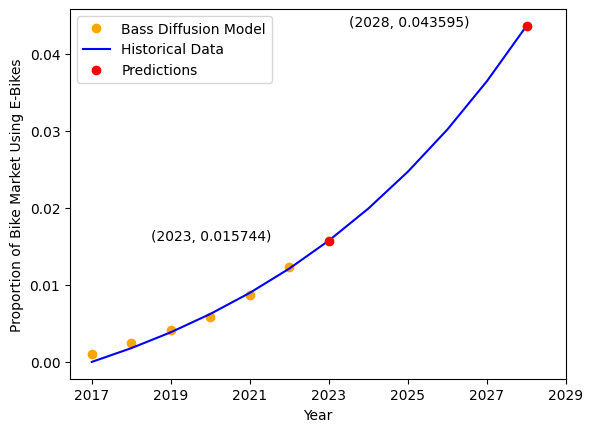

US Parameters: [0.00166242 0.14507636]


In [159]:
location = 'US'

# get the last year in the location data
last_year = dataframes[location]['Year'].iloc[-1]

# get the first year in the location data
first_year = dataframes[location]['Year'].iloc[0]

# fit to data
bass_popt, bass_pcov = curve_fit(bass_diffusion_model, dataframes[location]['year_diff'], dataframes[location]['cum_sum'], p0=[0.003, 0.17], maxfev=100000)

# add columns for predictions
dataframes[location]['bass'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt)

# take results dataframe as Year, year_diff, and bass
US_results = dataframes[location][['Year', 'year_diff', 'bass']]

# create new df with years from first_year to 2029
US_results = pd.DataFrame({'Year': range(first_year, 2029)})
US_results['year_diff'] = US_results['Year'] - first_year
US_results['bass'] = bass_diffusion_model(US_results['year_diff'], *bass_popt)

# plot original dataframe data
plt.plot(dataframes[location]['Year'], dataframes[location]['cum_sum'], 'o', color='orange')

# plot bass curve
plt.plot(US_results['Year'], US_results['bass'], color='blue')

#label the coordinate at x=2023 with (year, bass) to 6 decimal places

#get the bass value at year 2023
pred_2023 = US_results[US_results['Year'] == 2023]['bass'].iloc[0]
plt.plot(2023, pred_2023, 'o', color='red')
plt.annotate(f'(2023, {pred_2023:.6f})', xy=(2018.5, pred_2023))

#label the coordinate at x = 2028
pred_2028 = US_results[US_results['Year'] == 2028]['bass'].iloc[0]
plt.plot(2028, pred_2028, 'o', color='red')
plt.annotate(f'(2028, {pred_2028:.6f})', xy=(2023.5, pred_2028))

# set ticks to be every 2 years
plt.xticks(range(dataframes[location]['Year'].iloc[0], 2030, 2))

# label X axis as Year
plt.xlabel('Year')

# label Y axis as Proportion of Bike Market Using E-Bikes
plt.ylabel('Proportion of Bike Market Using E-Bikes')

# add legend with blue line for bass model, orange dots for original data, and red dots for predictions
plt.legend(['Bass Diffusion Model', 'Historical Data', 'Predictions'])

plt.show()
print("US Parameters: " + str(bass_popt))

In [160]:
# add column for change in bass
US_results['bass_change'] = US_results['bass'].diff()

# add bikes sold as bass_change times market size
US_results['bikes_sold'] = US_results['bass_change'] * market_size[location]
US_results

,Year,year_diff,bass,bass_change,bikes_sold
0,2017,0,0.000000,NaN,NaN
1,2018,1,0.001787,0.001787,455.781516
2,2019,2,0.003849,0.002062,525.786705
3,2020,3,0.006226,0.002377,606.180293
4,2021,4,0.008965,0.002739,698.382746
5,2022,5,0.012118,0.003153,803.968387
6,2023,6,0.015744,0.003626,924.668166
7,2024,7,0.019910,0.004166,1062.366834
8,2025,8,0.024691,0.004781,1219.092197
9,2026,9,0.030169,0.005478,1396.993626


## Regression for Europe Data

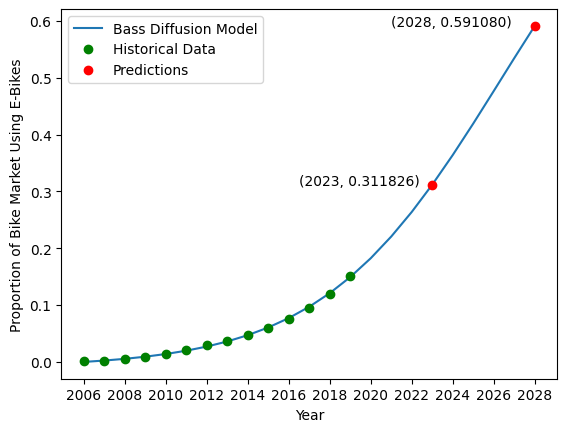

Europe Parameters: [0.00215364 0.22704352]


In [161]:
location = 'Europe'

# get the last year in the location data
last_year = dataframes[location]['Year'].iloc[-1]

# get the first year in the location data
first_year = dataframes[location]['Year'].iloc[0]

# define bass diffusion model
def bass_diffusion_model(x, p, q):
    return (1.0- np.exp(-1.0 * (p + q) * x))/(1 + q / p * np.exp(-1.0 * (p + q) * x))

# fit to data
bass_popt, bass_pcov = curve_fit(bass_diffusion_model, dataframes[location]['year_diff'], dataframes[location]['cum_sum'], p0=[0.003, 0.17], maxfev=100000)

# add columns for predictions
dataframes[location]['bass'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt)

# take results dataframe as Year, year_diff, and bass
europe_results = dataframes[location][['Year', 'year_diff', 'bass']]

# create new df with years from last year to 2029
europe_results = pd.DataFrame({'Year': range(first_year, 2029)})
europe_results['year_diff'] = europe_results['Year'] - first_year
europe_results['bass'] = bass_diffusion_model(europe_results['year_diff'], *bass_popt)

# plot results year against bass predictions and data
plt.plot(europe_results['Year'], europe_results['bass'])
plt.plot(dataframes[location]['Year'], dataframes[location]['cum_sum'], 'o', color='green')

#label the coordinate at x=2023 with (year, bass) to 6 decimal places
pred_2023 = europe_results[europe_results['Year'] == 2023]['bass'].iloc[0]
plt.plot(2023, pred_2023, 'o', color='red')
plt.annotate(f'(2023, {pred_2023:.6f})', xy=(2016.5, pred_2023))

#label the coordinate at x = 2028
pred_2028 = europe_results[europe_results['Year'] == 2028]['bass'].iloc[0]
plt.plot(2028, pred_2028, 'o', color='red')
plt.annotate(f'(2028, {pred_2028:.6f})', xy=(2021, pred_2028))

# set ticks to be every 2 years
plt.xticks(range(dataframes[location]['Year'].iloc[0], 2030, 2))

# label X axis as Year
plt.xlabel('Year')

# label Y axis as Proportion of Bike Market Using E-Bikes
plt.ylabel('Proportion of Bike Market Using E-Bikes')

# add legend with blue line for bass model, orange dots for original data, and red dots for predictions
plt.legend(['Bass Diffusion Model', 'Historical Data', 'Predictions'])


plt.show()
print("Europe Parameters: " + str(bass_popt))

In [162]:
# add column for change in bass
europe_results['bass_change'] = europe_results['bass'].diff()

# add bikes sold as bass_change times market size
europe_results['bikes_sold'] = europe_results['bass_change'] * market_size['UK']
europe_results

,Year,year_diff,bass,bass_change,bikes_sold
0,2006,0,0.000000,NaN,NaN
1,2007,1,0.002415,0.002415,81.958219
2,2008,2,0.005435,0.003020,102.509685
3,2009,3,0.009207,0.003772,128.037416
4,2010,4,0.013910,0.004703,159.646398
5,2011,5,0.019762,0.005852,198.630838
6,2012,6,0.027023,0.007261,246.474284
7,2013,7,0.036004,0.008981,304.827662
8,2014,8,0.047065,0.011061,375.451822
9,2015,9,0.060621,0.013555,460.107280
